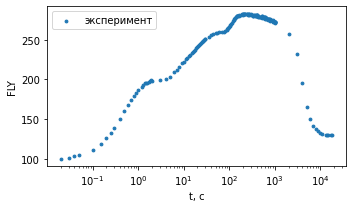

In [20]:
# Jupyter Notebook: Нелинейная наименьших квадратов (Levenberg–Marquardt / TRF) с `least_squares`


# %% Cell 1 — импорт и данные
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

# загрузка экспериментальных данных
data = np.loadtxt(
    '250522 Scenedesmus data experiment_1.txt',
    delimiter='\t',
    converters={0: lambda s: float(s.decode().replace(',','.')),
                1: lambda s: float(s.decode().replace(',','.'))},
    skiprows=1
)
t_exp, FLY_exp = data[:,0], data[:,1]

plt.figure(figsize=(5,3))
plt.scatter(t_exp, FLY_exp, s=8, label='эксперимент')
plt.xscale('log')
plt.xlabel('t, с'); plt.ylabel('FLY')
plt.legend(); plt.tight_layout()
plt.show()


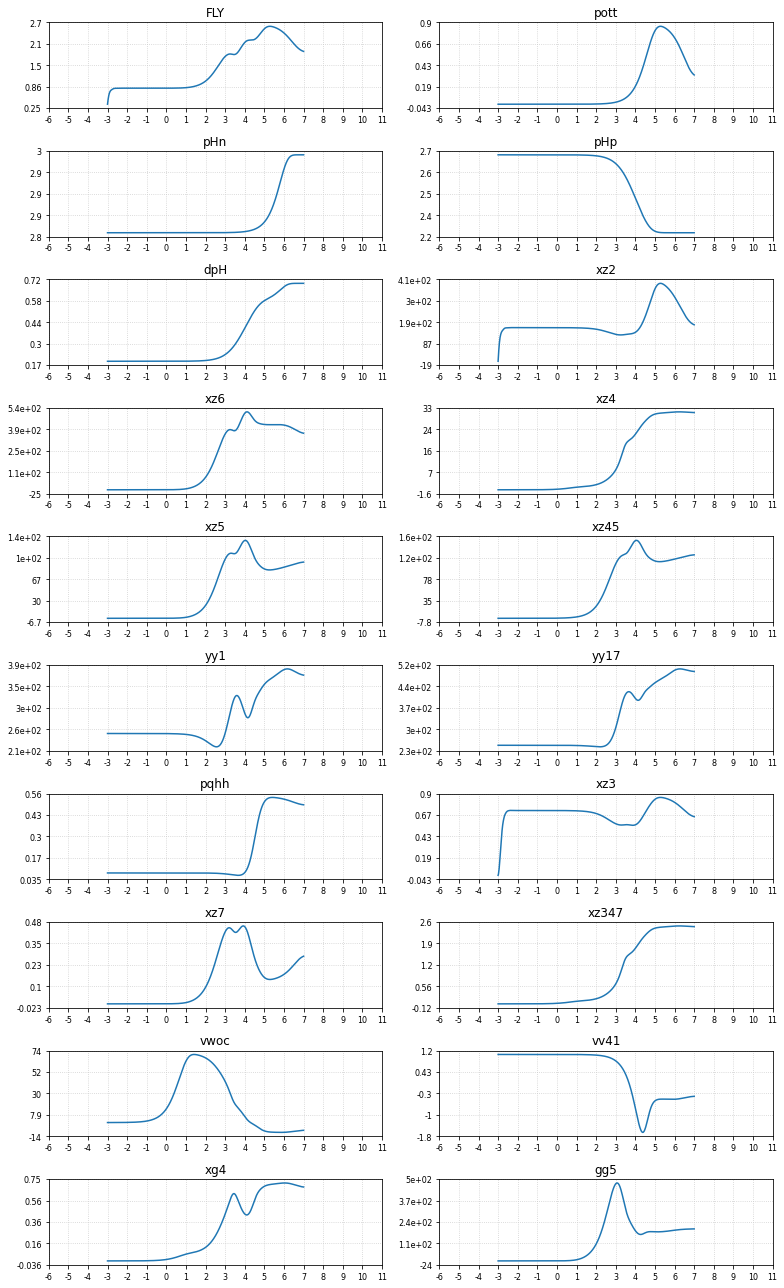

In [32]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Scenedesmus PSII model – full set of DBSolve observables
author: Dmitrii Chaikovskii, 2025-05-23
"""

import numpy as np
from math import exp, log10
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 1. исходные параметры (точно как в .txt)
# -------------------------------------------------------------
p = dict(
    k1=0.50,  k_1=6.7e4,
    antn=50.0,
    k2=3.2e8/50.0, KK2=10.0,
    kp680=1.1e6,
    kcar=0.0, tauc=0.06,
    kda=8.0e4,
    k3=3.0e6, KK3=1.0e7,
    kk4=200.0, KK4=64.0,
    k7=3.0,   KK7=10.0,
    k14=1.6,  KK14=4.0,
    k21=0.04, KK21=1.6,
    k34=0.2,  KK34=0.1,
    k41=0.1,  KK41=500.0,
    k51=1.0e5, k52=6.4,
    k53=7.0e5, k54=6.0,
    kpq=0.0,
    del1=0.5, del2=0.3, del3=0.1, del4=0.1,
    sk=45.0,  f0psI=0.008,
    tauw=0.6, tauw1=0.4,
    pot1=0.0015, pot2=0.0045, pot3=0.0030,
    tauhp=24.0, tauhp1=50.0,
    tauhn=500.0,
    taupt=40.0, taupt1=3000.0,
    cm=5.0, d=0.5,
    Pool1=17.2, Pool2=1.62,
    KK5=1.0,                 # в файле высчитан позже
)

# -------------------------------------------------------------
# 2. вспомогательные функции времени
# -------------------------------------------------------------
def Hp(t):
    t = np.asarray(t)
    return 2.4e-4 + 1.4e-3*(1 - np.exp(-t/p['tauhp'])) \
                   + 5.0e-4*(1 - np.exp(-t/p['tauhp1']))

def Hn(t):
    t = np.asarray(t)
    return 8.0e-5 - 4.0e-5*(1 - np.exp(-t/p['tauhn']))

def pt(t):
    t = np.asarray(t)
    return (p['pot1']
            - p['pot2']*np.exp(-t/p['taupt'])
            + p['pot3']*np.exp(-t/p['taupt1']))

def k4_t(t):
    t = np.asarray(t)
    return p['kk4']*np.exp(-t/p['tauw']) + 4.8

def elect(t):
    """kpot1…4, k_pot1…4, kz"""
    psi = p['d']*pt(t)*3760/p['cm']
    kp1 = exp(-p['del1']*psi); k_p1 = 1/kp1
    kp2 = exp(-p['del2']*psi); k_p2 = 1/kp2
    kp3 = exp(-p['del3']*psi); k_p3 = 1/kp3
    kp4 = exp(-p['del4']*psi); k_p4 = 1/kp4
    kz  = Hn(t)*1.0e4
    return kp1,k_p1,kp2,k_p2,kp3,k_p3,kp4,k_p4,kz

# -------------------------------------------------------------
# 3. индексы переменных
# -------------------------------------------------------------
S = ['x1','x2','x3','x4','x5','x6','x7',
     'y1','y2','y3','y4','y5','y6','y7',
     'z1','z2','z3','z4','z5','z6','z7',
     'PQH2',
     'g1','g2','g3','g4','g5','g6','g7',
     'PQ']
I = {s:i for i,s in enumerate(S)}

y0 = np.zeros(len(S))
y0[I['x1']] = 0.6
y0[I['y1']] = 0.4
y0[I['g1']] = 0.62
y0[I['PQ']] = 15.0
y0[I['PQH2']] = 1.2

# -------------------------------------------------------------
# 4. правая часть ( все V[1]…V[53] )
# -------------------------------------------------------------
def make_rhs(params):
    # пред-вычисления постоянных
    k2,k_2 = params['k2'], params['k2']/params['KK2']
    k3,k_3 = params['k3'], params['k3']/params['KK3']
    k5     = k2/10.0
    k_5    = k5/params['KK5']
    k_7    = params['k7']/params['KK7']
    k_14   = params['k14']/params['KK14']
    k_21   = params['k21']/params['KK21']
    k_34   = params['k34']/params['KK34']
    k_41   = params['k41']/params['KK41']
    k_1    = params['k_1']

    def rhs(t, y):
        (x1,x2,x3,x4,x5,x6,x7,
         y1,y2,y3,y4,y5,y6,y7,
         z1,z2,z3,z4,z5,z6,z7,
         PQH2,g1,g2,g3,g4,g5,g6,g7,PQ) = y

        kp1,k_p1,kp2,k_p2,kp3,k_p3,kp4,k_p4,kz = elect(t)
        Hp_t = Hp(t);   k4 = k4_t(t)
        p680 = (x3+y3+g3+z3 + x4+y4+g4+z4 + x7+y7+g7+z7)
        car  = params['kcar']*exp(-t/params['tauc'])

        V = np.zeros(54)
        V[1]=params['k1']*x1-(k_1+params['kp680']*p680+car)*x2
        V[2]=k2*x2*kp1 - k_2*x3*k_p1
        V[3]=k3*x3*kp2 - k_3*x4*k_p2
        V[4]=k4*x4*kp3 - (k4/params['KK4'])*x5*k_p3*Hp_t*1e4
        V[5]=params['k1']*x5-(k_1+params['kp680']*p680+params['kda']+car+params['kpq']*PQ)*x6
        V[6]=k5*x6*kp1 - k_5*x7*k_p1
        V[7]=params['k7']*x5 - k_7*y1
        V[8]=params['k1']*y1-(k_1+params['kp680']*p680+car)*y2
        V[9]=k2*y2*kp1 - k_2*y3*k_p1
        V[10]=k3*y3*kp2 - k_3*y4*k_p2
        V[11]=k4*y4*kp3 - (k4/params['KK4'])*y5*k_p3*Hp_t*1e4
        V[12]=params['k1']*y5-(k_1+params['kp680']*p680+params['kda']+car+params['kpq']*PQ)*y6
        V[13]=k5*y6*kp1 - k_5*y7*k_p1
        V[14]=params['k14']*y5*kz*kp4 - k_14*z1*k_p4
        V[15]=params['k1']*z1-(k_1+params['kp680']*p680+params['kda']+car+params['kpq']*PQ)*z2
        V[16]=k2*z2*kp1 - k_2*z3*k_p1
        V[17]=k3*z3*kp2 - k_3*z4*k_p2
        V[18]=k4*z4*kp3 - (k4/params['KK4'])*z5*k_p3*Hp_t*1e4
        V[19]=params['k1']*z5-(k_1+params['kp680']*p680+params['kda']+car+params['kpq']*PQ)*z6
        V[20]=k5*z6*kp1 - k_5*z7*k_p1
        for i,(Z,G) in enumerate([(z1,g1),(z2,g2),(z3,g3),(z4,g4),(z5,g5),(z6,g6),(z7,g7)],start=21):
            V[i]=params['k21']*Z*kz*kp4 - k_21*G*PQH2*k_p4
        V[28]=params['k1']*g1 - (k_1+params['kp680']*p680+car)*g2
        V[29]=k2*g2*kp1 - k_2*g3*k_p1
        V[30]=k3*g3*kp2 - k_3*g4*k_p2
        V[31]=k4*g4*kp3 - (k4/params['KK4'])*g5*k_p3*Hp_t*1e4
        V[32]=params['k1']*g5-(k_1+params['kp680']*p680+params['kda']+car+params['kpq']*PQ)*g6
        V[33]=k5*g6*kp1 - k_5*g7*k_p1
        V[34]=params['k34']*g1*PQ - k_34*x1
        V[35]=params['k34']*g2*PQ - k_34*x2
        V[36]=params['k34']*g3*PQ - k_34*x3
        V[37]=params['k34']*g4*PQ - k_34*x4
        V[38]=params['k34']*g5*PQ - k_34*x5
        V[39]=params['k34']*g6*PQ - k_34*x6
        V[40]=params['k34']*g7*PQ - k_34*x7
        V[41]=params['k41']*PQH2*kp3 - k_41*PQ*k_p3*(Hp_t*1e4)**2
        V[42:54]=[params['k51']*x3, params['k54']*x4, params['k53']*x7,
                  params['k51']*y3, params['k52']*y4, params['k53']*y7,
                  params['k51']*z3, params['k52']*z4, params['k53']*z7,
                  params['k51']*g3, params['k54']*g4, params['k53']*g7]

        # ---------- 30 ОДУ (d) ----------
        d = np.zeros_like(y)
        # x-ветка
        d[I['x1']] = -V[1]+V[34]+V[42]+V[43]
        d[I['x2']] =  V[1]-V[2]+V[35]
        d[I['x3']] =  V[2]-V[3]+V[36]-V[42]
        d[I['x4']] =  V[3]-V[4]+V[37]-V[43]
        d[I['x5']] =  V[4]-V[5]-V[7]+V[38]+V[44]
        d[I['x6']] =  V[5]-V[6]+V[39]
        d[I['x7']] =  V[6]+V[40]-V[44]
        # y-ветка
        d[I['y1']] =  V[7]-V[8]+V[45]+V[46]
        d[I['y2']] =  V[8]-V[9]
        d[I['y3']] =  V[9]-V[10]-V[45]
        d[I['y4']] =  V[10]-V[11]-V[46]
        d[I['y5']] =  V[11]-V[12]-V[14]+V[47]
        d[I['y6']] =  V[12]-V[13]
        d[I['y7']] =  V[13]-V[47]
        # z-ветка
        d[I['z1']] =  V[14]-V[15]-V[21]+V[48]+V[49]
        d[I['z2']] =  V[15]-V[16]-V[22]
        d[I['z3']] =  V[16]-V[17]-V[23]-V[48]
        d[I['z4']] =  V[17]-V[18]-V[24]-V[49]
        d[I['z5']] =  V[18]-V[19]-V[25]+V[50]
        d[I['z6']] =  V[19]-V[20]-V[26]
        d[I['z7']] =  V[20]-V[27]-V[50]
        # PQ / g-ветка
        d[I['PQH2']] = V[21]+V[22]+V[23]+V[24]+V[25]+V[26]+V[27]-V[41]
        d[I['g1']] = V[21]-V[28]-V[34]+V[51]+V[52]
        d[I['g2']] = V[22]+V[28]-V[29]-V[35]
        d[I['g3']] = V[23]+V[29]-V[30]-V[36]-V[51]
        d[I['g4']] = V[24]+V[30]-V[31]-V[37]-V[52]
        d[I['g5']] = V[25]+V[31]-V[32]-V[38]+V[53]
        d[I['g6']] = V[26]+V[32]-V[33]-V[39]
        d[I['g7']] = V[27]+V[33]-V[40]-V[53]
        d[I['PQ']]  = -(V[34]+V[35]+V[36]+V[37]+V[38]+V[39]+V[40])+V[41]

        # ------- сохраняем V для последующих наблюдаемых --------
        rhs.last_V = V    # not thread-safe, но здесь удобно
        rhs.last_p680 = p680
        return d

    rhs.last_V = None
    rhs.last_p680 = None
    return rhs

# -------------------------------------------------------------
# 5. интегрируем на лог-сетке
# -------------------------------------------------------------
t_eval = 10**np.linspace(-6, 4, 600)   # 1 µs … 10 s
solver_rhs = make_rhs(p)
sol = solve_ivp(solver_rhs, (t_eval[0], t_eval[-1]), y0,
                t_eval=t_eval, method='BDF',
                rtol=1e-6, atol=1e-9)

Y = sol.y.T        # (N, 30)
V_hist = []        # массивы потоков
p680_hist = []
for ti, yi in zip(sol.t, Y):
    solver_rhs(ti, yi)          # обновляет .last_V
    V_hist.append(solver_rhs.last_V.copy())
    p680_hist.append(solver_rhs.last_p680)
V_hist = np.vstack(V_hist)
p680_hist = np.array(p680_hist)

# -------------------------------------------------------------
# 6. вычисляем ВСЕ explicit-функции из файла
# -------------------------------------------------------------
Hp_arr = Hp(sol.t)
Hn_arr = Hn(sol.t)
pt_arr = pt(sol.t)

obs = dict(
    FLY = p['sk']*(p['f0psI'] + p['k_1']*(Y[:,I['x2']]+Y[:,I['x6']]
                                           +Y[:,I['y2']]+Y[:,I['y6']]
                                           +Y[:,I['z2']]+Y[:,I['z6']]
                                           +Y[:,I['g2']]+Y[:,I['g6']])),
    pott = 200*pt_arr,
    pHn  = -np.log10(0.001*Hn_arr)*0.4,
    pHp  = -np.log10(0.001*Hp_arr)*0.4,
    dpH  = (-np.log10(0.001*Hn_arr)*0.4
            - (-np.log10(0.001*Hp_arr)*0.4)),
    xz2  = 1.8e9*(Y[:,I['x2']]+Y[:,I['y2']]+Y[:,I['g2']]+Y[:,I['z2']])/1.62,
    xz6  = 1.8e9*(Y[:,I['x6']]+Y[:,I['y6']]+Y[:,I['g6']]+Y[:,I['z6']])/1.62,
    xz4  = 500*(Y[:,I['x4']]+Y[:,I['y4']]+Y[:,I['g4']]+Y[:,I['z4']])/1.62,
    xz5  = 500*(Y[:,I['x5']]+Y[:,I['y5']]+Y[:,I['g5']]+Y[:,I['z5']])/1.62,
    xz45 = (500*(Y[:,I['x4']]+Y[:,I['y4']]+Y[:,I['g4']]+Y[:,I['z4']])
            +500*(Y[:,I['x5']]+Y[:,I['y5']]+Y[:,I['g5']]+Y[:,I['z5']]))/1.62,
    yy1  = 1000*Y[:,I['y1']]/1.62,
    yy17 = 1000*(Y[:,I['y1']]+Y[:,I['y2']]+Y[:,I['y3']]+Y[:,I['y4']]
                 +Y[:,I['y5']]+Y[:,I['y6']]+Y[:,I['y7']])/1.62,
    pqhh = Y[:,I['PQH2']]/(Y[:,I['PQH2']]+Y[:,I['PQ']]+1e-12),
    xz3  = 4.5e6*(Y[:,I['x3']]+Y[:,I['y3']]+Y[:,I['g3']]+Y[:,I['z3']])/1.62,
    xz7  = 4.5e6*(Y[:,I['x7']]+Y[:,I['y7']]+Y[:,I['g7']]+Y[:,I['z7']])/1.62,
    xz347 = 40*np.array(p680_hist)/1.62,
    vwoc = 100*(V_hist[:,11]+V_hist[:,4]+V_hist[:,18]+V_hist[:,31]),
    vv41 = 10*V_hist[:,41],
    xg4  = 40*(Y[:,I['x4']]+Y[:,I['g4']])/1.62,
    gg5  = 7050*Y[:,I['g5']]/1.62,
    yy5  = 7050*Y[:,I['y5']]/1.62,
    zz5  = 7050*Y[:,I['z5']]/1.62,
    xx5  = 7050*Y[:,I['x5']]/1.62,
)
obs['xg5'] = obs['xx5'] + obs['gg5']   # определяется после xx5 и gg5

# -------------------------------------------------------------
# 7. вывод — многооконное изображение
# -------------------------------------------------------------
time_log = np.log10(sol.t*1e3)     # log10 (мс)
# определяем позиции меток по оси X (от –6 до +1)
xticks = np.arange(-6, 12, 1)
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(11,18),
                         sharex=True)
for ax, (name, values) in zip(axes.ravel(), obs.items()):
    ax.plot(time_log, values)
    ax.set_title(name)
    ax.grid(ls=':', color='0.8')
        # добавляем метки на оси X
    # добавляем метки на оси X
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(t) for t in xticks], fontsize=8)
    # если хотите показывать подписи на всех графиках, а не только на нижнем ряду:
    ax.tick_params(labelbottom=True)

    # --- Y: линейная шкала, равномерные подписи ---
    ymin, ymax = ax.get_ylim()
    yticks = np.linspace(ymin, ymax, 5)            # 5 меток
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{y:.2g}" for y in yticks], fontsize=8)
   
#axes[-1,0].set_xlabel(r'$\log_{10}(t\,[\mathrm{ms}])$')
#axes[-1,1].set_xlabel(r'$\log_{10}(t\,[\mathrm{ms}])$')
# Общая подпись оси X
#fig.supxlabel(r'$\log_{10}\bigl(t\,[\mathrm{ms}]\bigr)$', fontsize=12)
plt.tight_layout()
plt.show()


In [22]:
# %% Cell 3 — подгоняем только положительные параметры в лог-пространстве
# отбираем ключи, для которых p[k]>0
param_keys = [k for k,v in p.items() if v>0]
x0 = np.array([p[k] for k in param_keys])
u0 = np.log(x0)            # стартовое u = ln(p)

def simulate_FLY_from_u(u):
    # пробрасываем оптимизируемые
    p_fit = p.copy()
    for k,val in zip(param_keys, np.exp(u)):
        p_fit[k] = val
    rhs = make_rhs(p_fit)
    sol = solve_ivp(rhs, (t_exp[0],t_exp[-1]), y0,
                    t_eval=t_exp, method='BDF',
                    rtol=1e-6, atol=1e-9)
    Y = sol.y.T
    fly = p_fit['sk']*(
        p_fit['f0psI']
        + p_fit['k_1']*(
            Y[:,I['x2']]+Y[:,I['x6']]
          + Y[:,I['y2']]+Y[:,I['y6']]
          + Y[:,I['z2']]+Y[:,I['z6']]
          + Y[:,I['g2']]+Y[:,I['g6']]
        )
    )
    return fly

def residuals_rel(u):
    return (simulate_FLY_from_u(u) - FLY_exp) / FLY_exp


In [23]:
# %% Cell 4 — TRF с bounds, robust‐loss и защитой от NaN/∞
import numpy as np
from scipy.optimize import least_squares

# 1) фильтруем только положительные параметры
param_keys = [k for k,v in p.items() if v>0]
x0 = np.array([p[k] for k in param_keys])
u0 = np.log(x0)

# 2) задаём границы: каждый параметр в [p/1e3, p*1e3]
p_low  = {k: max(p[k]*1e-3, 1e-12) for k in param_keys}
p_high = {k:        p[k]*1e3          for k in param_keys}
u_low  = np.log([p_low[k]  for k in param_keys])
u_high = np.log([p_high[k] for k in param_keys])

# 3) безопасная функция невязок
def residuals_rel_safe(u):
    try:
        fly = simulate_FLY_from_u(u)
        r = (fly - FLY_exp) / FLY_exp
        if not np.all(np.isfinite(r)):
            raise ValueError
        return r
    except:
        # большой штраф, если ODE не решилось или появились NaN/∞
        return np.ones_like(FLY_exp) * 1e6

# 4) собственно вызов least_squares
res = least_squares(
    residuals_rel_safe,
    u0,
    jac='2-point',
    method='trf',            # trust‐region reflective
    bounds=(u_low, u_high),
    loss='soft_l1',          # сглаженный l1 → робастность к выбросам
    f_scale=0.1,
    xtol=1e-12,
    ftol=1e-12,
    gtol=1e-12,
    max_nfev=2000,
    verbose=2
)

# 5) восстанавливаем параметры
u_opt = res.x
p_opt = p.copy()
for k,val in zip(param_keys, np.exp(u_opt)):
    p_opt[k] = val

print("TRF fit success:", res.success, res.message)
print("\nОптимальные параметры:")
for k in sorted(p_opt):
    print(f"  {k}: {p_opt[k]:.4g}")


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6392e+01                                    1.17e+00    
       1              5         1.5753e+01      6.39e-01       9.60e-01       5.63e+00    
       2              6         2.2109e+00      1.35e+01       1.86e+00       1.21e+01    
       3              7         1.3118e+00      8.99e-01       3.88e+00       3.90e+01    
       4              8         1.1490e+00      1.63e-01       9.44e-01       6.86e+01    
       5              9         9.4721e-01      2.02e-01       2.47e-01       1.62e+01    
       6             12         9.4708e-01      1.38e-04       1.60e-02       6.57e+00    
       7             13         9.4608e-01      9.92e-04       3.80e-03       1.73e+01    
       8             14         9.4582e-01      2.63e-04       9.20e-04       1.33e+01    
       9             15         9.4580e-01      1.82e-05       2.52e-04       5.11e+00    

In [24]:
# %% Cell 4 — вызов least_squares
# начальное приближение
x0 = np.array([p[k] for k in param_keys], dtype=float)

res = least_squares(
    residuals_all,
    x0,
    jac='2-point',      # приближённая оценка Якобиана
    method='trf',       # trust-region reflective (поддерживает bounds)
    bounds=(0, np.inf), # если хотим неотрицательные параметры
    xtol=1e-10,
    ftol=1e-10,
    gtol=1e-10,
    max_nfev=2000
)

print("Статус:", res.message)
fitted = dict(zip(param_keys, res.x))
print("\nОптимальные параметры:")
for k, v in fitted.items():
    print(f"  {k}: {v:.4g}")


NameError: name 'residuals_all' is not defined

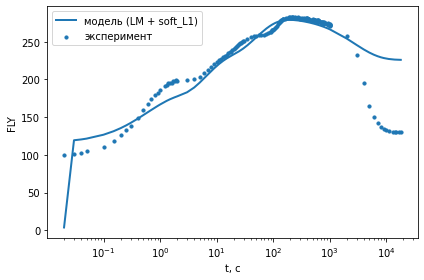

In [25]:
# %% Cell 5 — финальный график
FLY_fit = simulate_FLY_from_u(u_opt)

plt.scatter(t_exp, FLY_exp, s=10, label='эксперимент')
plt.plot(t_exp, FLY_fit, '-', lw=2, label='модель (LM + soft_L1)')
plt.xscale('log'); plt.xlabel('t, с'); plt.ylabel('FLY')
plt.legend(); plt.tight_layout(); plt.show()


In [27]:
from scipy.optimize import differential_evolution, least_squares

# границы в лог-преобразовании (u = ln p), как мы уже делали:
bounds = list(zip(u_low, u_high))

# 1) Глобальный поиск (минимизируем сумму квадратов относительной невязки)
def loss_sum(u):
    r = residuals_rel_safe(u)
    return np.sum(r**2)

result_de = differential_evolution(
    loss_sum,
    bounds,
    maxiter=1000,
    popsize=15,
    tol=1e-3,
    polish=False,    # не полируем сразу встроенным методом
    disp=True
)
u_de = result_de.x

# 2) Локальная доводка LM (начиная с решения DE)
res_lm = least_squares(
    residuals_rel_safe,
    u_de,
    jac='2-point',
    method='lm',
    loss='linear',
    xtol=1e-12, ftol=1e-12, gtol=1e-12,
    max_nfev=500
)

u_opt = res_lm.x
p_opt = p.copy()
for k,val in zip(param_keys, np.exp(u_opt)):
    p_opt[k] = val

print("DE→LM success:", res_lm.success, res_lm.message)
for k,v in p_opt.items():
    print(f"{k} = {v:.4g}")


differential_evolution step 1: f(x)= 7.27879
differential_evolution step 2: f(x)= 6.11535
differential_evolution step 3: f(x)= 6.11535
differential_evolution step 4: f(x)= 6.00638
differential_evolution step 5: f(x)= 5.11177
differential_evolution step 6: f(x)= 5.11177
differential_evolution step 7: f(x)= 5.11177
differential_evolution step 8: f(x)= 5.11177
differential_evolution step 9: f(x)= 5.11177
differential_evolution step 10: f(x)= 5.11177
differential_evolution step 11: f(x)= 4.47886
differential_evolution step 12: f(x)= 4.47886
differential_evolution step 13: f(x)= 4.47886
differential_evolution step 14: f(x)= 4.47886
differential_evolution step 15: f(x)= 4.47886
differential_evolution step 16: f(x)= 4.47886
differential_evolution step 17: f(x)= 3.7313
differential_evolution step 18: f(x)= 3.7313
differential_evolution step 19: f(x)= 3.7313
differential_evolution step 20: f(x)= 3.7313
differential_evolution step 21: f(x)= 3.7313
differential_evolution step 22: f(x)= 3.7313
dif

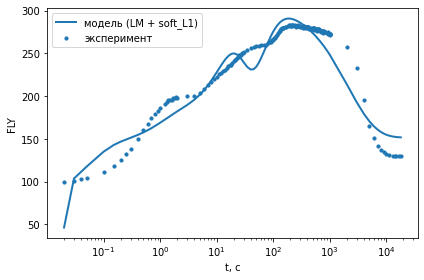

In [28]:
# %% Cell 5 — финальный график
FLY_fit = simulate_FLY_from_u(u_opt)

plt.scatter(t_exp, FLY_exp, s=10, label='эксперимент')
plt.plot(t_exp, FLY_fit, '-', lw=2, label='модель (LM + soft_L1)')
plt.xscale('log'); plt.xlabel('t, с'); plt.ylabel('FLY')
plt.legend(); plt.tight_layout(); plt.show()


In [29]:
from scipy.optimize import differential_evolution, least_squares

# границы в лог-преобразовании (u = ln p), как мы уже делали:
bounds = list(zip(u_low, u_high))

# 1) Глобальный поиск (минимизируем сумму квадратов относительной невязки)
def loss_sum(u):
    r = residuals_rel_safe(u)
    return np.sum(r**2)

result_de = differential_evolution(
    loss_sum,
    bounds,
    maxiter=1000,
    popsize=15,
    tol=1e-3,
    polish=False,    # не полируем сразу встроенным методом
    disp=True
)
u_de = result_de.x

# 2) Локальная доводка LM (начиная с решения DE)
res_lm = least_squares(
    residuals_rel_safe,
    u_de,
    jac='2-point',
    method='lm',
    loss='linear',
    xtol=1e-12, ftol=1e-12, gtol=1e-12,
    max_nfev=500
)

u_opt = res_lm.x
p_opt = p.copy()
for k,val in zip(param_keys, np.exp(u_opt)):
    p_opt[k] = val

print("DE→LM success:", res_lm.success, res_lm.message)
for k,v in p_opt.items():
    print(f"{k} = {v:.4g}")


differential_evolution step 1: f(x)= 5.77682
differential_evolution step 2: f(x)= 5.77682
differential_evolution step 3: f(x)= 5.77682
differential_evolution step 4: f(x)= 5.77682
differential_evolution step 5: f(x)= 4.85586
differential_evolution step 6: f(x)= 4.85586
differential_evolution step 7: f(x)= 4.85586
differential_evolution step 8: f(x)= 4.85586
differential_evolution step 9: f(x)= 4.85586
differential_evolution step 10: f(x)= 3.44698
differential_evolution step 11: f(x)= 3.44698
differential_evolution step 12: f(x)= 3.44698
differential_evolution step 13: f(x)= 3.44698
differential_evolution step 14: f(x)= 3.44698
differential_evolution step 15: f(x)= 3.44698
differential_evolution step 16: f(x)= 3.44698
differential_evolution step 17: f(x)= 3.44698
differential_evolution step 18: f(x)= 3.44698
differential_evolution step 19: f(x)= 3.44698
differential_evolution step 20: f(x)= 3.44698
differential_evolution step 21: f(x)= 3.44698
differential_evolution step 22: f(x)= 3.446

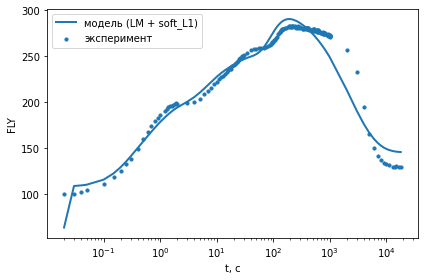

In [30]:
# %% Cell 5 — финальный график
FLY_fit = simulate_FLY_from_u(u_opt)

plt.scatter(t_exp, FLY_exp, s=10, label='эксперимент')
plt.plot(t_exp, FLY_fit, '-', lw=2, label='модель (LM + soft_L1)')
plt.xscale('log'); plt.xlabel('t, с'); plt.ylabel('FLY')
plt.legend(); plt.tight_layout(); plt.show()

In [31]:
print("from u_opt:",  u_opt['sk'], u_opt['f0psI'], u_opt['k_1'])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices